In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW
using Plots


In [62]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [3]:
# function active_weights(W,z)
#     return diagm(Int.((W*z) .> 0))*W
# end


# function HingeLoss_0(y; slope=-10, eps = .1)
#     return sum((max.(0,slope .* y .- eps .* slope)).^2)/size(y,2)
# end

# function HingeLoss_1(y; slope = 10, eps = .1)
#     return sum((max.(0, slope .* y .- slope .* (1+eps) )).^2 )/size(y,2)
# end

# function Hinge_0_1(y;slope = 1)
#     max.(-1 .*max.(0, abs.(y) ) .+ 1, 0)
# end

# function BCE_own(ŷ, y; ϵ =1e-5)
#     sum(@.(-y * log(Hinge_0_1_v2(ŷ) +ϵ) - (1 - y) * log(Hinge_0_1(ŷ) + ϵ)))/size(y,2)
# end


# function Hinge_0_1_v2(y;slope = 1)
#     max.(-1 .* max.(0, abs.(y - 1 )) + 1 , 0)
# end

In [63]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, W1, W2, W3, Q, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), W1 = cpu(W1), W2 = cpu(W2), W3 = cpu(W3), Q = cpu(Q)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    W1 = randn(500,20)
    W2 = randn(500,500)
    W3 = randn(500,500)
    Q = randn(784,500)

    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end


# function sigmoid_scaled(x)
#     α = (exp(1) + exp(-1))/(exp(1) - exp(-1))
#     return α * (exp(x) - exp(-x))/(exp(x) + exp(-x)) 
# end

# function BCE_own(ŷ, y; ϵ =1e-5)
#     α = (exp(1) + exp(-1))/(exp(1) - exp(-1))
#     sum(@.(-y * log( α + sigmoid_scaled(ŷ)  +ϵ) - (1 - y) * log(1 - sigmoid(ŷ)/sigmoid(1) + ϵ)))/size(y,2)
# end
# y = randn(5)
# ŷ = randn(5)
# α = (exp(1) + exp(-1))/(exp(1) - exp(-1))


function sig_shifted_v2(x)
    M = 0.375261028309015
    X = 0.624697168346519
    α = X/0.5
    sig(x) = exp(-x^2)*tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

function sig_shifted(x)
    M = 1.04187855854289
    X = 1.01570942991227
    α = X/0.25
    sig(x) = (exp(-x^2)+.99) * tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

function sig_shifted_v3(x)
    M = 0.321140015957206
    X = 0.58703932739034
    α = X/0.5
    sig(x) = (exp(-x^2) - .1)*tanh(x)
    return @.(sig(α*(x-.5))/(2M)  + 1/2)
end

function BCE_own(x̂,x)
    return sum( @.( -(1-x)*log(1 - (sigmoid(abs(1-x̂)) .- .5) * min((abs(x̂))^1.01, 1) + 1e-5)  - x*( log(1 - (sigmoid(abs(1-x̂)) .- .5)* min((abs(1-x̂))^1.01, 1)  + 1e-5) ) ) )/784
end

function BCE_own(x̂)
    invgaus(x) =  @.(-exp(-(x)^2) +1)
    return sum( @.( - log(1 - invgaus( max( abs(.5-x̂) -.5 , .5 ) -.5 ) + 1e-5)  ) )/size(x̂,2)
end

function  logit_BCE(x̂,x) 
    return sum(@.(- x * log( sigmoid(x̂) + 1e-5) - (1-x)* log( 1 - sigmoid(x̂) + 1e-5))) / size(x,2)
end

function  logit_BCE_shifted(x̂,x) 
    return sum(@.(- x * log( sig_shifted(x̂) + 1e-4) - (1-x)* log( 1 - sig_shifted(x̂) + 1e-4))) / size(x,2)
end

BCE_own(randn(700))

165.61993400560496

In [21]:
BCE_own

BCE_own (generic function with 2 methods)

In [60]:
function vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, Q, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = Q*relu(W2*relu(W1*z))

    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = sum(logit_BCE.(x̂, x))
    loss_mse = sum(BCE_own.(x̂))

    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, W1, W2, Q))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty

    # println("$(loss_mse)     $(elbo)        $(logp_x_z)")
    return -elbo + reg + loss_mse + logp_x_z #+ 10*norm(x̂, Inf) #+ 7000 * α 
end

function train(encoder_μ, encoder_logvar, W1, W2, W3, Q, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, W1, W2, W3, Q)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 31:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, Q, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, W1, W2, W3, Q, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [61]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0


num_epochs = 50

save_dir = "trained_GNN/MNIST_unenforced_v2"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
# encoder_μ, encoder_logvar, W1, W2, W3, Q  = create_vae()
train(encoder_μ, encoder_logvar, W1, W2, W3, Q, dataloader, num_epochs, λ, β, ADAM(η, (0.9,0.8)), save_dir)

1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    31        21497.6
Saving model...Done

Training a epoch done   4%|██                            |  ETA: 0:22:48



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    32        16650.1
Saving model...Done



Training a epoch done   6%|██                            |  ETA: 0:22:09


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    33        16384.7
Saving model...Done


Training a epoch done   8%|███                           |  ETA: 0:21:35



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    34        16277.7
Saving model...Done


Training a epoch done  10%|████                          |  ETA: 0:21:04



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    35        16206.2
Saving model...Done


Training a epoch done  12%|████                          |  ETA: 0:20:34



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    36        16153.2
Saving model...Done



Training a epoch done  14%|█████                         |  ETA: 0:20:05


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    37        16112.1
Saving model...Done


Training a epoch done  16%|█████                         |  ETA: 0:19:36



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    38        16077.9
Saving model...Done


Training a epoch done  18%|██████                        |  ETA: 0:19:07



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    39        16046.4
Saving model...Done



Training a epoch done  20%|███████                       |  ETA: 0:18:39


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    40        16016.5
Saving model...Done


Training a epoch done  22%|███████                       |  ETA: 0:18:10



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    41        15993.3
Saving model...Done


Training a epoch done  24%|████████                      |  ETA: 0:17:42



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    42        15972.6
Saving model...Done



Training a epoch done  26%|████████                      |  ETA: 0:17:14


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    43        15954.5
Saving model...Done


Training a epoch done  28%|█████████                     |  ETA: 0:16:48



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    44        15935.1
Saving model...Done



Training a epoch done  30%|██████████                    |  ETA: 0:16:20


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    45        15921.9
Saving model...Done


Training a epoch done  32%|██████████                    |  ETA: 0:15:53



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    46        15907.9
Saving model...Done



Training a epoch done  34%|███████████                   |  ETA: 0:15:25


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    47        15891.1
Saving model...Done



Training a epoch done  36%|███████████                   |  ETA: 0:14:56


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    48        15883.4
Saving model...Done



Training a epoch done  38%|████████████                  |  ETA: 0:14:28


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    49        15867.6
Saving model...Done


Training a epoch done  40%|█████████████                 |  ETA: 0:14:01



1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    50        15857.4
Saving model...Done
Training complete!


In [11]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, Q, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = Q*relu(W2*relu(W1*z))
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 20
    epoch_to_load = 20
    # Load the model and test set loader
    dir = "trained_GNN/MNIST_unenforced_v2"
    encoder_μ, encoder_logvar, W1, W2, W3, Q = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, Q, x_batch)
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [12]:
visualise()

Loading model...

Done


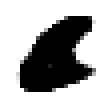

In [12]:
load("trained_GNN/MNIST_unenforced_v2/reconstruction-3.png")

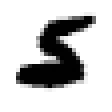

In [13]:
load("trained_GNN/MNIST_unenforced_v2/test-image-3.png")

Loading model...Done


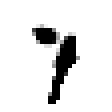

In [58]:
function subspace_incoherence(F, A)
    m, _ = size(A)
    Q = Matrix(qr(A).Q)
    temp = Q'*F'
    return maximum(sqrt.(sum(temp.*temp, dims = 1)))

end


epoch_to_load = 30
# Load the model and test set loader
dir = "trained_GNN/MNIST_unenforced_v2"
encoder_μ, encoder_logvar, W1, W2, W3, Q = load_model_identity(dir, epoch_to_load)

colorview(Gray, reshape(Q*relu(W2*relu(W1*randn(20))), 28,28)' )
# F = dct(diagm(ones(784)),2);
# subspace_incoherence(F,Q)

# _,s,_, =svd(W3);
# s


In [48]:
# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

a= x_batch[:,i];
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

b= x_batch[:,i];

a = randn(784)
b = randn(784)

BCE_abs(a,a)



┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


-1.0447461576998724